## Imports

In [2]:
import time

import numpy as np
import cv2 as cv
import os
import glob
import matplotlib.pyplot as plt
from cv2 import cvtColor
from numpy.random import uniform
import pdb
from tqdm import tqdm

import utils
from utils import show_image_matplot,show_image_cv

In [ ]:
game_tables = utils.extract_game(utils.get_image_paths("antrenare",1))

In [4]:
relevant_game_tables = utils.extract_relevant_game(game_tables)

100%|██████████| 50/50 [00:00<00:00, 125.45it/s]


In [5]:
delimited_tables = utils.draw_lines(relevant_game_tables)

100%|██████████| 50/50 [00:00<00:00, 958.51it/s]


In [6]:
# utils.store_template_numbers1(10)
# utils.store_template_numbers2(8)

100%|██████████| 1/1 [00:00<00:00, 86.18it/s]


In [7]:
# utils.store_binary_templates(100,"./templates/sample1","./templates_binary/sample1")
# utils.store_binary_templates(100)

In [114]:
from utils import get_mathable_pieces_numbers, get_lines_coords


def classify_number(patch,templates_path = "./templates_cropped"):

    maxi = -np.inf
    chosen_number = -1
    numbers = get_mathable_pieces_numbers()

    num_whites_patch = np.sum(patch == 255)

    for number in numbers:
        template = cv.imread(templates_path+ "/" + str(number) + ".jpg")
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

        num_whites_template = np.sum(template == 255)

        if num_whites_template * 1.95 < num_whites_patch:
            continue

        corr = cv.matchTemplate(patch,template, cv.TM_CCOEFF_NORMED)
        corr=np.max(corr)

        if corr > maxi:
            maxi = corr
            chosen_number = number


    return chosen_number

def get_number_pos(binary_image,offset):
    lines_vertical,lines_horizontal = get_lines_coords()

    coords=[]
    patches = []

    for i in range(len(lines_horizontal)-1):
        for j in range(len(lines_vertical)-1):

            y_min = lines_vertical[j][0][0] + offset
            y_max = lines_vertical[j + 1][1][0] - offset
            x_min = lines_horizontal[i][0][1] + offset
            x_max = lines_horizontal[i + 1][1][1] - offset

            patch = binary_image[x_min:x_max,y_min:y_max].copy()
            patches.append(patch)

            if (i==6 or i==7) and (j==6 or j==7):
                continue

            mean = np.mean(binary_image[x_min+20:x_max-20,y_min+20:y_max-20].copy())


            if mean > 0:
                predicted_number = classify_number(patch)
                coords.append((i,j,predicted_number))
            #     show_image_matplot("patch " + str(i)+ " " + str(j) + " "+ str(predicted_number), patch)
            # else:
            #     show_image_matplot("patch " + str(i)+ " " + str(j), patch)
    return coords,patches


In [112]:

def crop_and_store_templates(templates_path = "./templates_binary/sample2",store_path = "./templates_cropped"):
    files = os.listdir(templates_path)

    for file in tqdm(files):
        path = templates_path + "/" + file
        template = cv.imread(path)
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

        height,width= template.shape
        x_min = -1
        x_max = -1
        y_min = -1
        y_max = -1

        for i in range(0,height):
            if y_min != -1:
                break
            for j in range(0,width):
                if template[i,j] == 255:
                    y_min = i
                    break

        for j in range(0,width):
            if x_min != -1:
                break
            for i in range(0,height):
                if template[i,j] == 255:
                    x_min = j
                    break

        for i in range(height-1,0,-1):
            if y_max != -1:
                break
            for j in range(0,width):
                if template[i,j] == 255:
                    y_max = i
                    break

        for j in range(width-1,0,-1):
            if x_max != -1:
                break
            for i in range(0,height):
                if template[i,j] == 255:
                    x_max = j
                    break

        cropped_template = template[y_min:y_max, x_min:x_max]

        cv.imwrite(store_path+"/"+file,cropped_template)


# new_templates = crop_and_store_templates()



In [115]:

all_sample = utils.extract_game(["./imagini_auxiliare/03.jpg"])
all_sample = utils.extract_relevant_game(all_sample)[0]

all_sample = cv.cvtColor(all_sample, cv.COLOR_BGR2GRAY)
_,all_sample = cv.threshold(all_sample,70,255,cv.THRESH_BINARY_INV)

# show_image_cv("",all_sample,fx=0.3,fy = 0.3)

sample = relevant_game_tables[49]
sample = cv.cvtColor(sample,cv.COLOR_BGR2GRAY)
_,sample = cv.threshold(sample,70,255,cv.THRESH_BINARY_INV)

coords,patches = get_number_pos(sample,offset = 8)

100%|██████████| 1/1 [00:00<00:00, 96.44it/s]


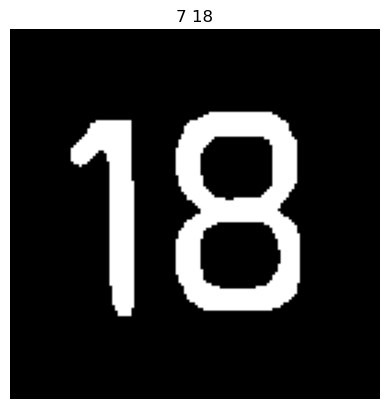

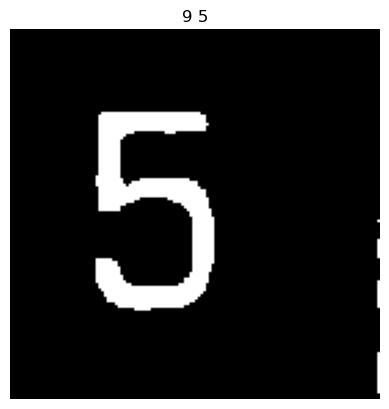

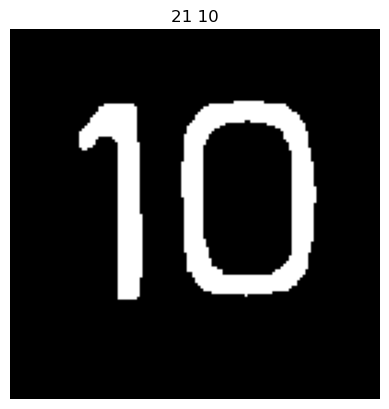

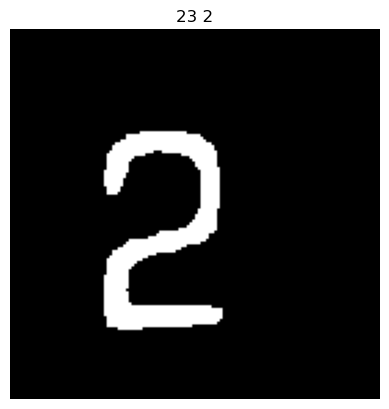

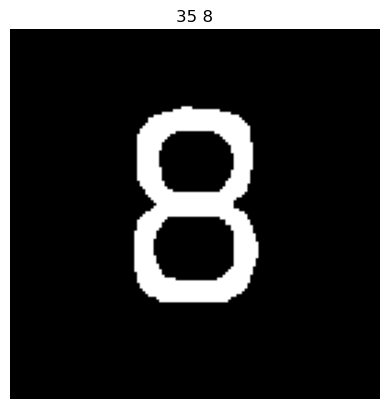

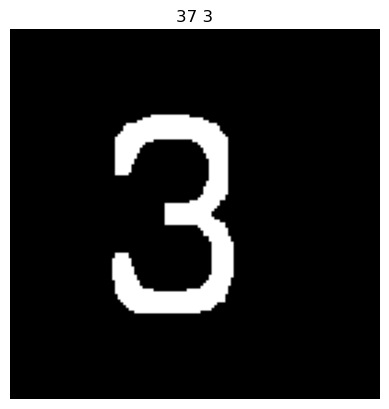

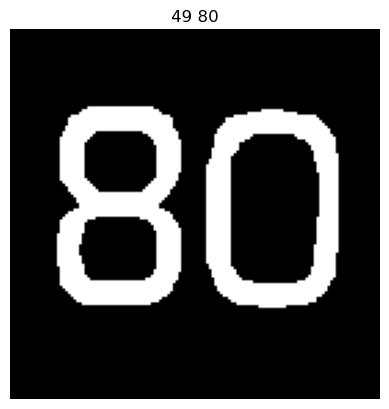

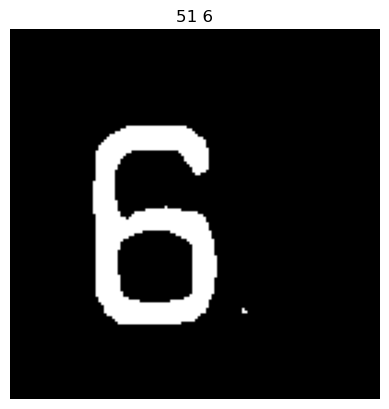

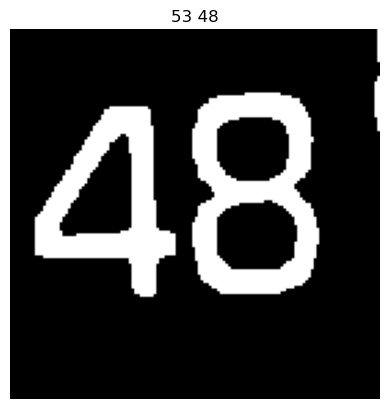

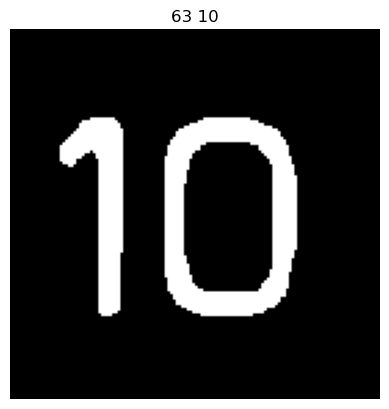

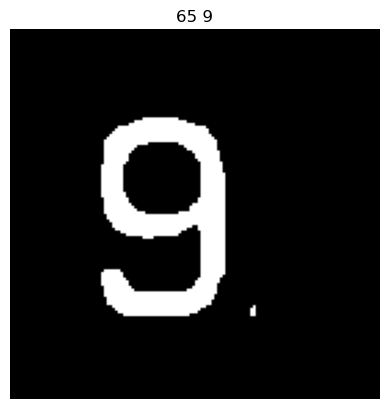

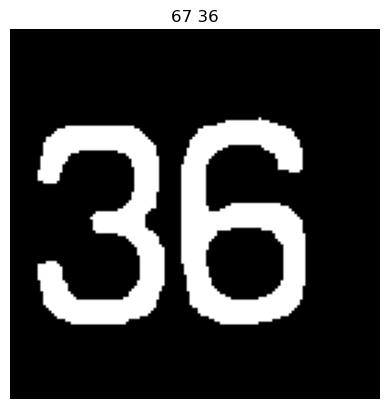

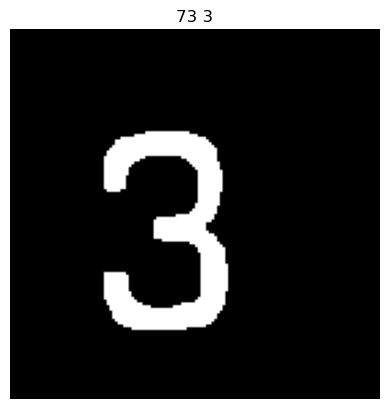

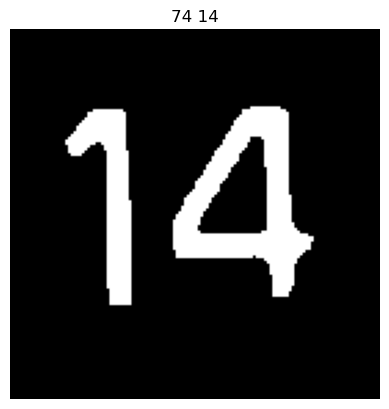

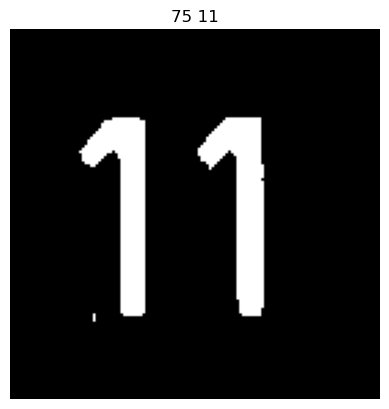

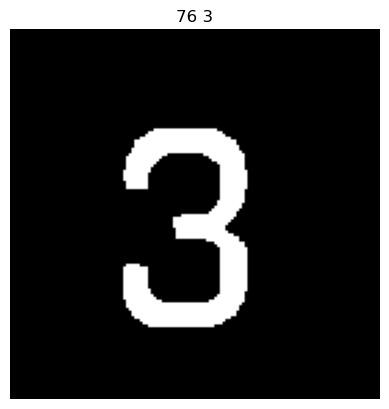

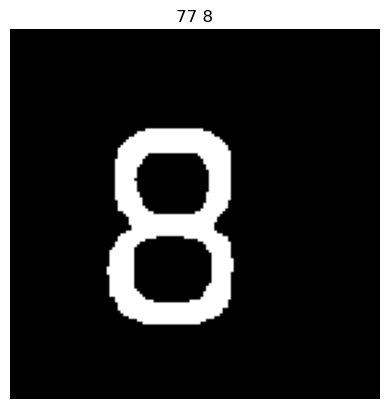

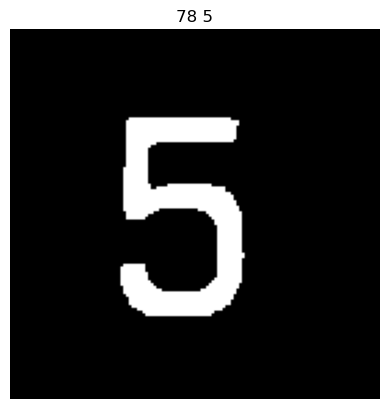

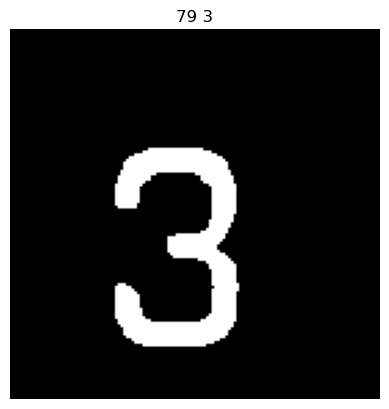

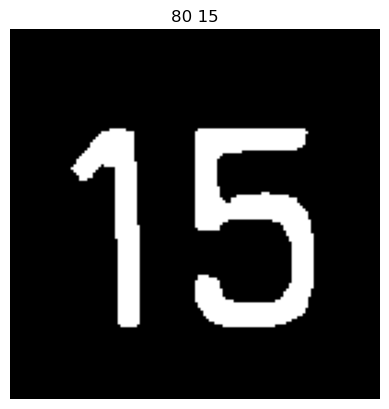

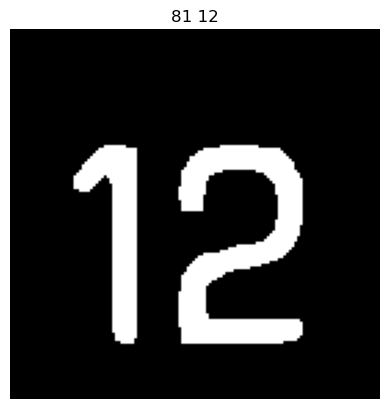

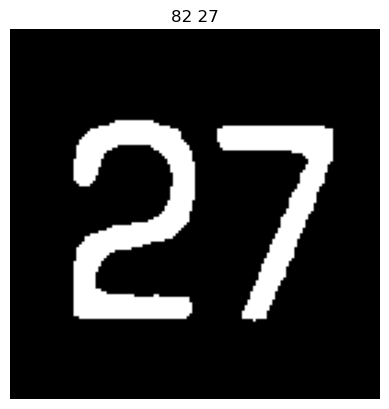

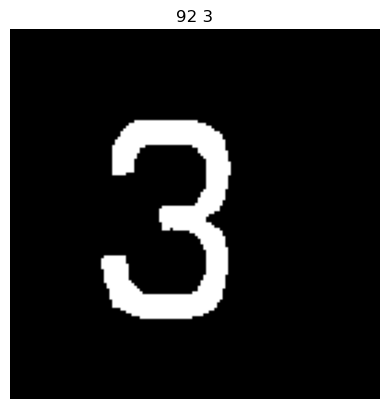

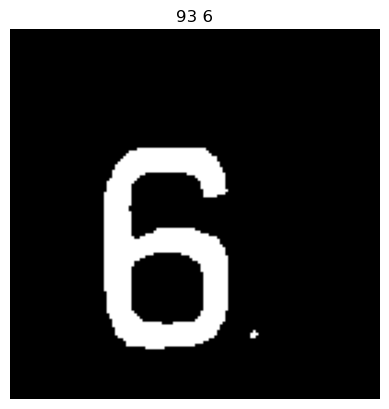

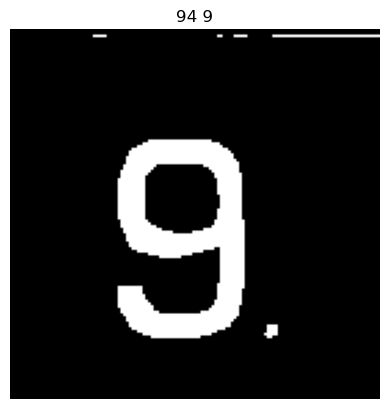

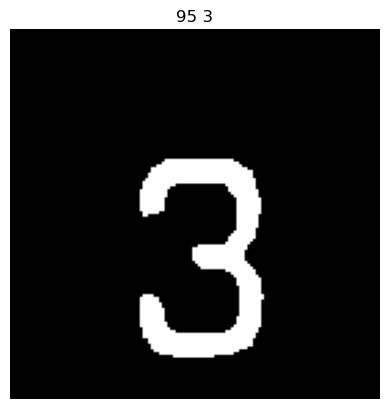

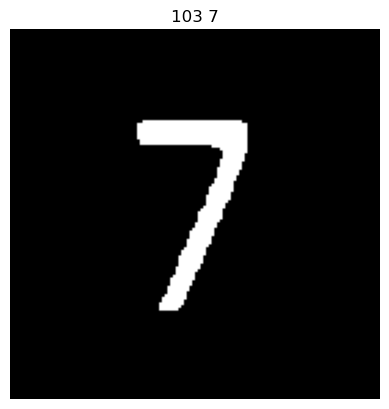

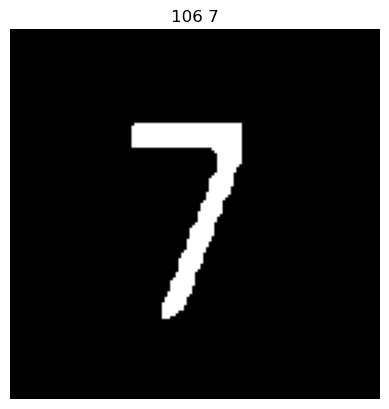

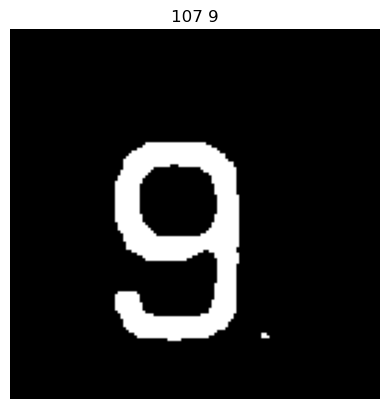

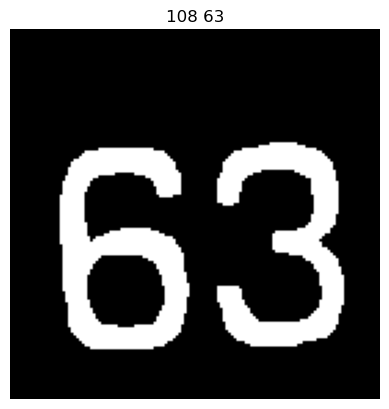

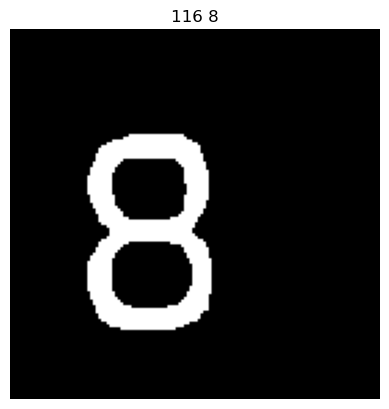

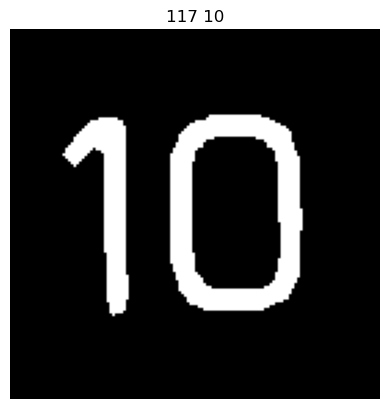

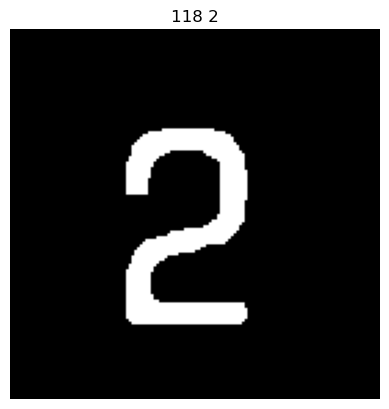

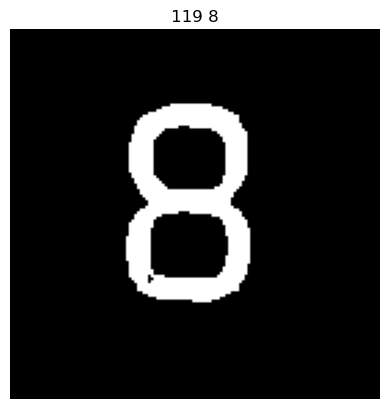

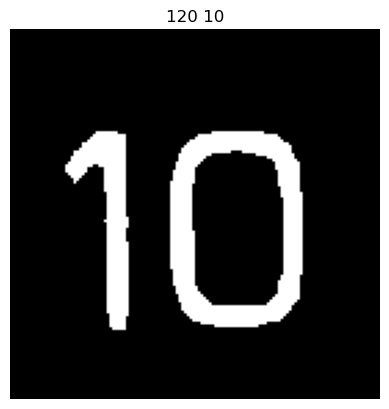

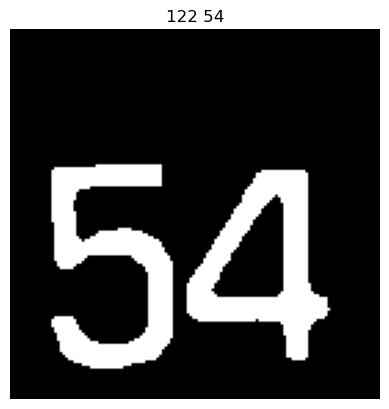

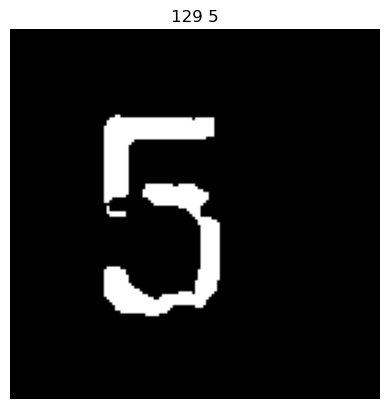

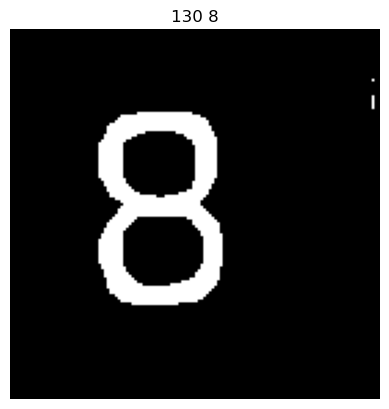

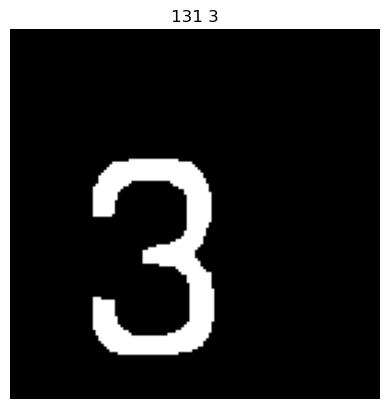

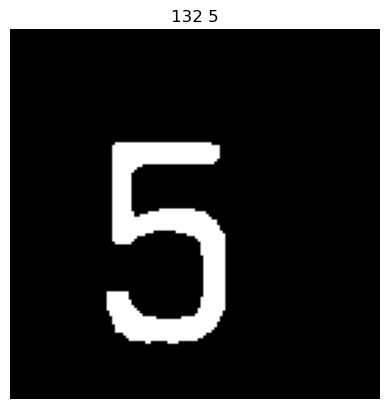

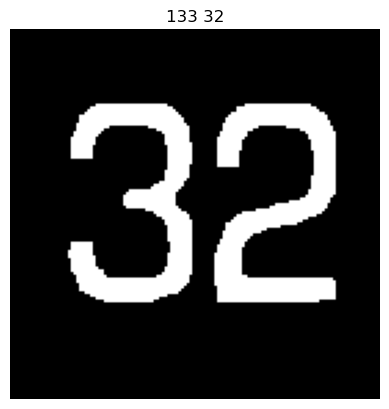

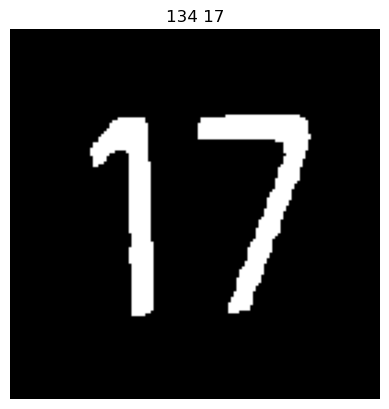

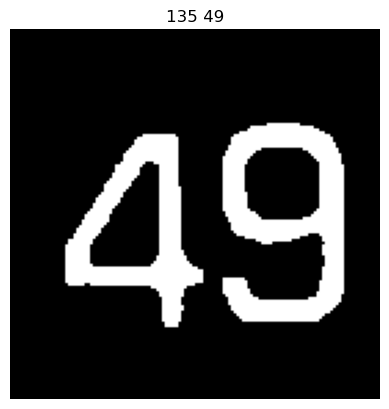

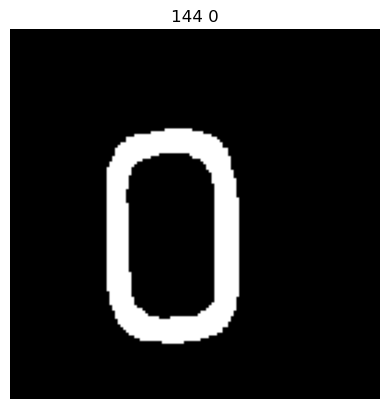

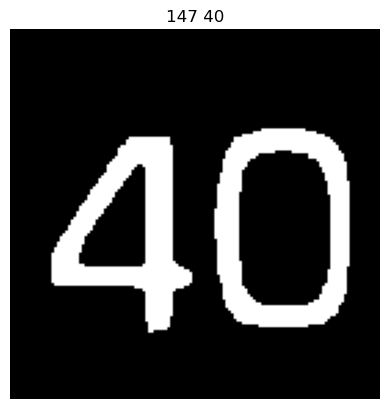

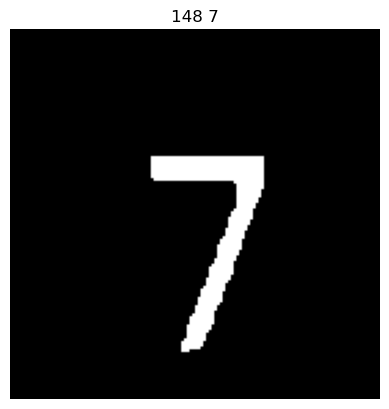

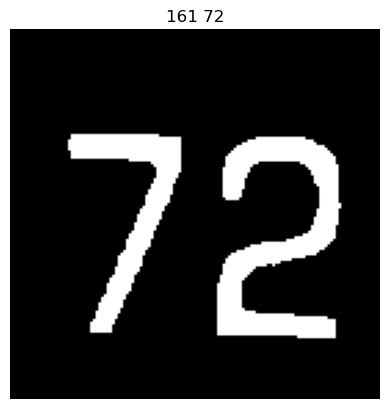

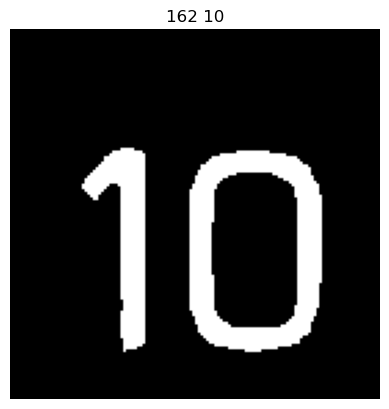

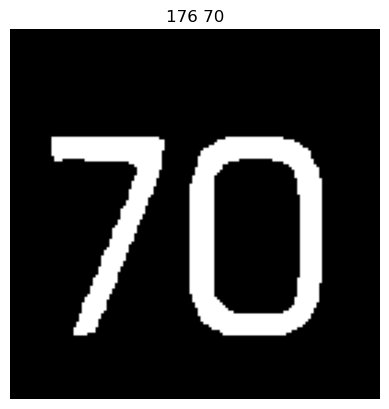

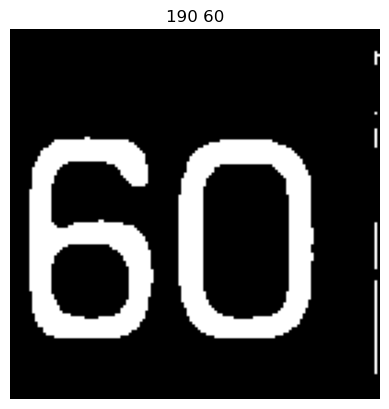

In [116]:
for coord in coords:
    index = 14 * coord[0] + coord[1]
    patch = patches[index]
    show_image_matplot(str(index) + " " +str(coord[2]),patch)

In [110]:

sample = patches[7]
one = cv.imread("templates_cropped/18.jpg")
one = cv.cvtColor(one,cv.COLOR_BGR2GRAY)
eleven = cv.imread("templates_cropped/8.jpg")
eleven = cv.cvtColor(eleven,cv.COLOR_BGR2GRAY)

corr1 = cv.matchTemplate(sample,one, cv.TM_CCOEFF_NORMED)
corr2 = cv.matchTemplate(sample,eleven, cv.TM_CCOEFF_NORMED)
corr1=np.max(corr1)
corr2=np.max(corr2)
print(corr1,corr2)

0.8445498 0.84946597


In [96]:

def select_and_save_roi(image_path, save_path):
    image = cv.imread(image_path)

    roi = cv.selectROI("Select ROI", image, showCrosshair=True)
    cv.destroyWindow("Select ROI")

    x, y, w, h = map(int, roi)
    selected_area = image[y:y+h, x:x+w]

    cv.imwrite(save_path, selected_area)

def rewrite_all(src_path = "./templates_handmade/new",dest_path = "./templates_cropped"):
    files = os.listdir(src_path)

    for file in files:
        old_path = src_path + "/" + file
        new_path = dest_path + "/" + file
        image = cv.imread(old_path)
        cv.imwrite(new_path,image)

rewrite_all()
